In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, matthews_corrcoef
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import shap
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'GPU' if device.type == 'cuda' else 'CPU'} Available")

GPU Available


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


from google.colab import drive
drive.mount('/content/drive')

模型改成自己的模型
前向传播修改成只返回最终的预测结果：

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,   # 减少 Attention 的特征维度
            num_heads=8,      # 减少注意力头数量
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,  # Attention 输出维度减少
            hidden_size=128,   # 减少 GRU 的 hidden_size
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)  # 减少 hidden_size

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),  # 减少输出维度
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x2.unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x3.unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)    # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)    # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)    # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)   # (batch_size, 1, 128)
        out2 = self.cnn2(x2).permute(0, 2, 1)   # (batch_size, 1, 128)
        out3 = self.cnn3(x3).permute(0, 2, 1)   # (batch_size, 1, 256)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 512)
        #merged = out2
        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 512)

        # BiGRU
        # BiGRU
        bigru_out, _ = self.bilstm(attn_out)  # 只传入 merged
         #(batch_size, seq_len, 128)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 8)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import numpy as np
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1).permute(0, 2, 1)
        x2 = x2.unsqueeze(1).permute(0, 2, 1)
        x3 = x3.unsqueeze(1).permute(0, 2, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)
        out2 = self.cnn2(x2).permute(0, 2, 1)
        out3 = self.cnn3(x3).permute(0, 2, 1)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)

        # Attention
        attn_out, _ = self.attention(merged, merged, merged)

        # BiGRU
        bigru_out, _ = self.bigru(attn_out)

        # 全连接层
        mlp_out = self.fc1(bigru_out)
        out = self.fc2(mlp_out).squeeze(-1)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]

        return final_out


In [5]:
model_path = r'/content/model_7.pt'
model = Net()
try:
    model.load_state_dict(torch.load(model_path, weights_only=False), strict=True)
except Exception as e:
    print(f"Error loading model: {e}")
model.eval()

# 载入训练集，分开载入正负样本，为了保证 SHAP 的背景样本正负均衡
data_frame = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=False)
# 训练集正样本
X_train_n = data_frame[0:1004, 1:]
y_train_n = data_frame[0:1004, 0]
# 训练集负样本
X_train_p = data_frame[1059:, 1:]
y_train_p = data_frame[1059:, 0]

# 载入测试集
test_data_frame = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=False)
X_test = test_data_frame[:, 1:]
y_test = test_data_frame[:, 0:1]

# 将 y_test 移动到 CPU 并转换为 NumPy 数组
y_test = y_test.cpu().numpy()

label = pd.DataFrame(y_test, columns=['label'])
print('X_test shape:', X_test.shape)
print('label shape', label.shape)

Error loading model: PytorchStreamReader failed reading zip archive: failed finding central directory
X_test shape: torch.Size([478, 2559])
label shape (478, 1)


In [ ]:
model = Net()
model_path = r'/content/model_7.pt'
# 保存状态字典
torch.save(model.state_dict(), model_path)
# 载入训练集，这里假设每个训练数据文件中前半部分是正样本，后半部分是负样本
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt')  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt')  # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt')  # (batch_size, 1024)

train_labels_list = [1] * 1004 + [0] * 1059  # 正负样本标签
train_label = torch.tensor(train_labels_list, dtype=torch.float)

# 训练集正样本
X_train_n_1 = train_data_1[0:1004, :]
X_train_n_2 = train_data_2[0:1004, :]
X_train_n_3 = train_data_3[0:1004, :]
y_train_n = train_label[0:1004]

# 训练集负样本
X_train_p_1 = train_data_1[1004:, :]
X_train_p_2 = train_data_2[1004:, :]
X_train_p_3 = train_data_3[1004:, :]
y_train_p = train_label[1004:]

# 载入测试集
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt')
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt')
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt')

# 测试集打标签
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32)

X_test_1 = test_data_1
X_test_2 = test_data_2
X_test_3 = test_data_3
label = pd.DataFrame(test_label, columns=['label'])

print('X_test_1 shape:', X_test_1.shape)
print('X_test_2 shape:', X_test_2.shape)
print('X_test_3 shape:', X_test_3.shape)
print('label shape', label.shape)

X_test_1 shape: torch.Size([478, 1024])
X_test_2 shape: torch.Size([478, 1280])
X_test_3 shape: torch.Size([478, 2560])
label shape (478, 1)


<ipython-input-10-2a5e52528a5d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt')  # (batch_size, 

In [ ]:
# 加载模型
model = Net()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# 准备测试数据
X_test_1 = X_test_1.to(device)
X_test_2 = X_test_2.to(device)
X_test_3 = X_test_3.to(device)

<ipython-input-11-562226808674>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
import torch
import shap
import matplotlib.pyplot as plt

# 加载模型
model = Net()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# 准备测试数据
X_test_1 = X_test_1.to(device)
X_test_2 = X_test_2.to(device)
X_test_3 = X_test_3.to(device)

# 创建 SHAP 解释器
background = [
    torch.zeros_like(X_test_1[:100]),  # 背景数据，形状与 X_test_1 一致
    torch.zeros_like(X_test_2[:100]),  # 背景数据，形状与 X_test_2 一致
    torch.zeros_like(X_test_3[:100])   # 背景数据，形状与 X_test_3 一致
]
explainer = shap.DeepExplainer(model, background)

# 计算 SHAP 值
shap_values = explainer.shap_values([X_test_1, X_test_2, X_test_3])

# 检查 SHAP 值的结构
print(len(shap_values))  # 应该输出 3
for i, sv in enumerate(shap_values):
    print(f"SHAP values for input {i}: {sv.shape}")

# 可视化 SHAP 值
shap.summary_plot(shap_values[0], X_test_1.cpu().numpy(), feature_names=["Feature 1"])
shap.summary_plot(shap_values[1], X_test_2.cpu().numpy(), feature_names=["Feature 2"])
shap.summary_plot(shap_values[2], X_test_3.cpu().numpy(), feature_names=["Feature 3"])

# 保存 SHAP 图
plt.savefig('shap_summary_plot.png')

<ipython-input-15-e92e62341fe1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


IndexError: tuple index out of range

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,   # 减少 Attention 的特征维度
            num_heads=8,      # 减少注意力头数量
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,  # Attention 输出维度减少
            hidden_size=128,   # 减少 GRU 的 hidden_size
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)  # 减少 hidden_size

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),  # 减少输出维度
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x2.unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x3.unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)    # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)    # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)    # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)   # (batch_size, 1, 256)
        out2 = self.cnn2(x2).permute(0, 2, 1)   # (batch_size, 1, 256)
        out3 = self.cnn3(x3).permute(0, 2, 1)   # (batch_size, 1, 512)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 1024)
        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 1024)

        # BiLSTM
        bigru_out, _ = self.bilstm(attn_out)  # (batch_size, seq_len, 256)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 16)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out

# 假设 X_train_p 和 X_train_n 是三个特征的训练数据，每个都是三元组 (x1, x2, x3)
# 这里只是示例数据，实际使用时需要替换为真实数据
X_train_p = [(torch.randn(100, 1024), torch.randn(100, 1280), torch.randn(100, 2560)) for _ in range(10)]
X_train_n = [(torch.randn(100, 1024), torch.randn(100, 1280), torch.randn(100, 2560)) for _ in range(10)]

# 选取正负各100个样本作为背景
# 分别对三个特征进行采样
background_p_x1 = shap.sample(torch.cat([x[0] for x in X_train_p], dim=0), nsamples=100, random_state=123)
background_p_x2 = shap.sample(torch.cat([x[1] for x in X_train_p], dim=0), nsamples=100, random_state=123)
background_p_x3 = shap.sample(torch.cat([x[2] for x in X_train_p], dim=0), nsamples=100, random_state=123)

background_n_x1 = shap.sample(torch.cat([x[0] for x in X_train_n], dim=0), nsamples=100, random_state=123)
background_n_x2 = shap.sample(torch.cat([x[1] for x in X_train_n], dim=0), nsamples=100, random_state=123)
background_n_x3 = shap.sample(torch.cat([x[2] for x in X_train_n], dim=0), nsamples=100, random_state=123)

# 拼接正负样本的背景数据
background_x1 = torch.concat([background_p_x1, background_n_x1], dim=0)
background_x2 = torch.concat([background_p_x2, background_n_x2], dim=0)
background_x3 = torch.concat([background_p_x3, background_n_x3], dim=0)

print('Background shape x1:', background_x1.shape)
print('Background shape x2:', background_x2.shape)
print('Background shape x3:', background_x3.shape)

# 创建一个新的类来封装模型和包装逻辑
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, *inputs):
        if len(inputs) < 3:
            raise ValueError("至少需要提供 3 个输入参数 (x1, x2, x3)。")
        x1, x2, x3 = inputs[:3]
        return self.model(x1, x2, x3)

model = Net()
wrapped_model = WrappedModel(model)
background = [background_x1, background_x2, background_x3]
explainer = shap.DeepExplainer(wrapped_model, background)

Background shape x1: torch.Size([200, 1024])
Background shape x2: torch.Size([200, 1280])
Background shape x3: torch.Size([200, 2560])


IndexError: tuple index out of range

分析整个测试集

In [ ]:
shap_values = explainer.shap_values(X_test, check_additivity=False)

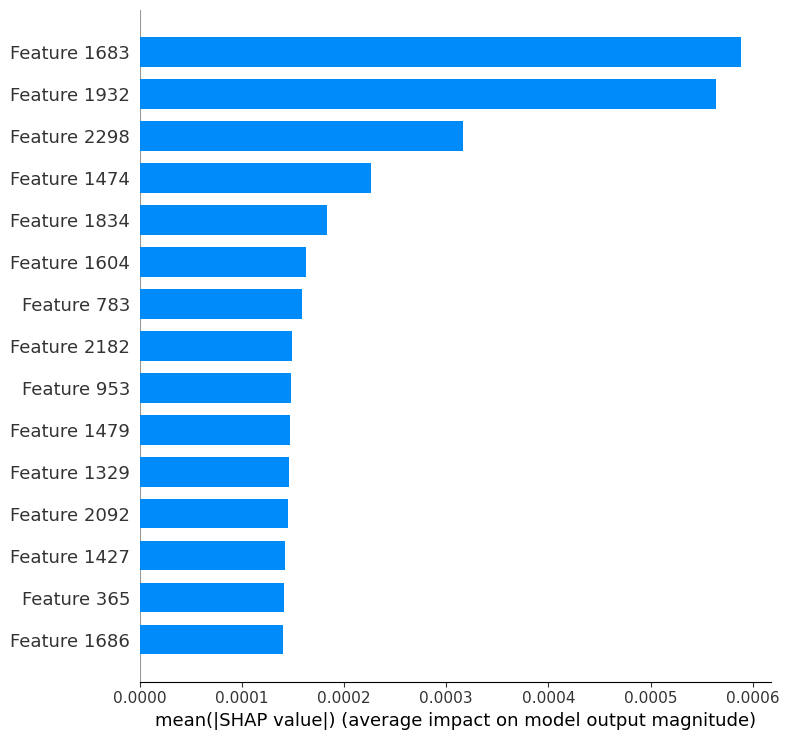

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15)

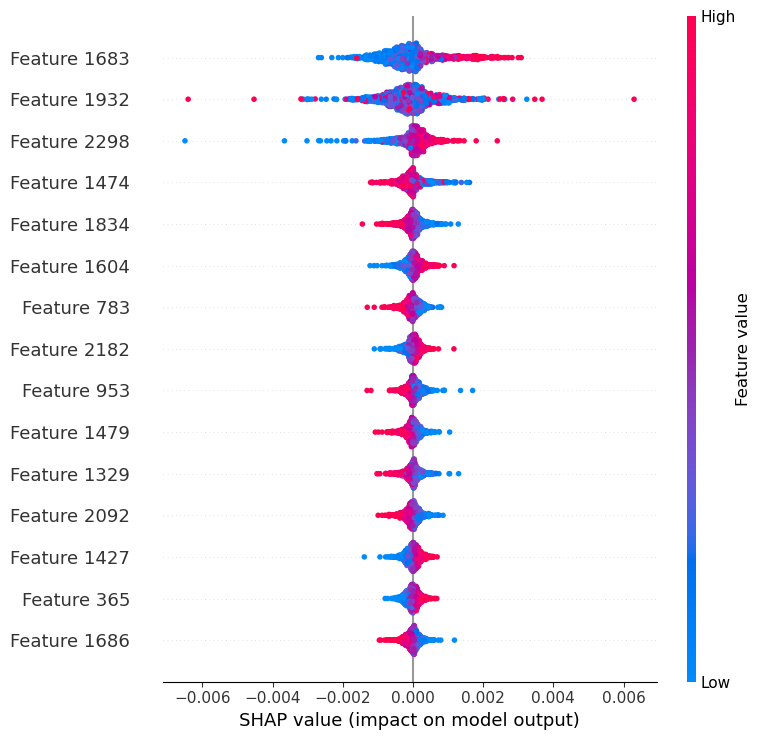

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=15)

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import random
from utils import caculate_metric
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'GPU' if device.type == 'cuda' else 'CPU'} Available")
# 固定随机种子等操作
seed_n = 911
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)

# 模型权重保存地址
model_save_path_list = r''

Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 1/30, Loss: 0.6978480815887451
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 2/30, Loss: 0.6893397569656372
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 3/30, Loss: 0.681190550327301
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 4/30, Loss: 0.6726193428039551
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 5/30, Loss: 0.6638643145561218
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2063, 1024])
Epoch 6/30, Loss: 0.6572826504707336
Input x1 shape: torch.Size([2063, 2560]), x2 shape: torch.Size([2063, 1280]), x3 shape: torch.Size([2

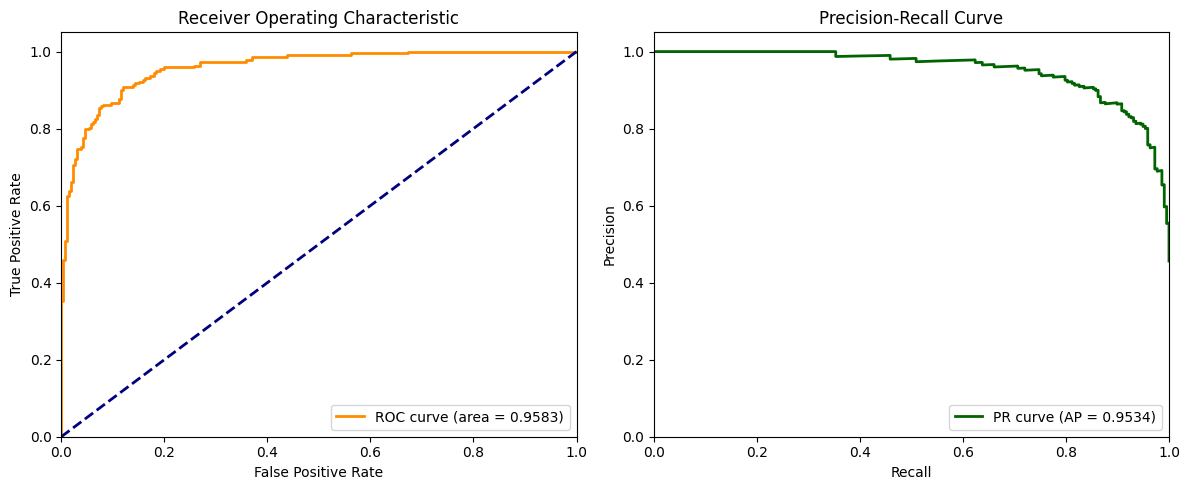

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# 检查 GPU 是否可用并定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义你的 Net 类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        # 检查输入维度（调试用，确认无误后可删除）
        print(f"Input x1 shape: {x1.shape}, x2 shape: {x2.shape}, x3 shape: {x3.shape}")

        # 确保输入为 2 维 (batch_size, feature)，若有多余维度先压缩
        if x1.dim() > 2:
            x1 = x1.squeeze(-1)
        if x2.dim() > 2:
            x2 = x2.squeeze(-1)
        if x3.dim() > 2:
            x3 = x3.squeeze(-1)

        x1 = x1.unsqueeze(1)
        x2 = x2.unsqueeze(1)
        x3 = x3.unsqueeze(1)

        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)
        x3 = x3.permute(0, 2, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)
        out2 = self.cnn2(x2).permute(0, 2, 1)
        out3 = self.cnn3(x3).permute(0, 2, 1)

        merged = torch.cat([out1, out2, out3], dim=-1)
        attn_out, _ = self.attention(merged, merged, merged)
        bigru_out, _ = self.bilstm(attn_out)
        mlp_out = self.fc1(bigru_out)
        out = self.fc2(mlp_out).squeeze(-1)
        final_out = out[:, -1]

        return final_out

# 加载训练数据并移动到设备
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True).to(device)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True).to(device)      # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True).to(device) # (batch_size, 1024)

# 标签并移动到设备
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float).to(device)

# 加载测试数据并移动到设备
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt', weights_only=True).to(device)
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt', weights_only=True).to(device)
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=True).to(device)

# 测试集标签并移动到设备
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32).to(device)

# 初始化模型、损失函数和优化器，并将模型移动到设备
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_data_3, train_data_2, train_data_1)
    loss = criterion(outputs, train_label)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    test_outputs = model(test_data_3, test_data_2, test_data_1)
    test_outputs = test_outputs.cpu().numpy()  # 将结果移回 CPU 以便转换为 NumPy
    test_label = test_label.cpu().numpy()

# 计算 ROC 曲线和 AUC
fpr, tpr, _ = roc_curve(test_label, test_outputs)
roc_auc = auc(fpr, tpr)

# 计算 PR 曲线和平均精确率 (Average Precision)
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(test_label, test_outputs)
average_precision = average_precision_score(test_label, test_outputs)

# 绘制 ROC 曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 绘制 PR 曲线
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AP = {average_precision:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import shap

# 检查 GPU 是否可用并定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义你的 Net 类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        # 确保输入为 2 维 (batch_size, feature)，若有多余维度先压缩
        if x1.dim() > 2:
            x1 = x1.squeeze(-1)
        if x2.dim() > 2:
            x2 = x2.squeeze(-1)
        if x3.dim() > 2:
            x3 = x3.squeeze(-1)

        x1 = x1.unsqueeze(2)  # 调整维度为 (batch_size, 2560, 1)
        x2 = x2.unsqueeze(2)  # 调整维度为 (batch_size, 1280, 1)
        x3 = x3.unsqueeze(2)  # 调整维度为 (batch_size, 1024, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)
        out2 = self.cnn2(x2).permute(0, 2, 1)
        out3 = self.cnn3(x3).permute(0, 2, 1)

        merged = torch.cat([out1, out2, out3], dim=-1)
        attn_out, _ = self.attention(merged, merged, merged)
        bigru_out, _ = self.bilstm(attn_out)
        mlp_out = self.fc1(bigru_out)
        out = self.fc2(mlp_out).squeeze(-1)
        final_out = out[:, -1]

        return final_out

# 加载训练数据并移动到设备
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True).to(device)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True).to(device)      # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True).to(device) # (batch_size, 1024)

# 标签并移动到设备
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float).to(device)

# 加载测试数据并移动到设备
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt', weights_only=True).to(device)
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt', weights_only=True).to(device)
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=True).to(device)

# 测试集标签并移动到设备
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32).to(device)

# 初始化模型、损失函数和优化器，并将模型移动到设备
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # 修正输入顺序
    outputs = model(train_data_1, train_data_2, train_data_3)
    loss = criterion(outputs, train_label)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    # 修正输入顺序
    test_outputs = model(test_data_1, test_data_2, test_data_3)
    test_outputs = test_outputs.cpu().numpy()  # 将结果移回 CPU 以便转换为 NumPy
    test_label = test_label.cpu().numpy()

# 计算 SHAP 值
# 定义一个包装函数，将输入转换为 PyTorch 张量并调用模型
def model_wrapper(inputs):
    x1 = torch.tensor(inputs[:, :2560], dtype=torch.float32).to(device)
    x2 = torch.tensor(inputs[:, 2560:2560+1280], dtype=torch.float32).to(device)
    x3 = torch.tensor(inputs[:, 2560+1280:], dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(x1, x2, x3)
    return outputs.cpu().numpy()

# 合并测试数据
test_data = np.hstack([test_data_1.cpu().numpy(), test_data_2.cpu().numpy(), test_data_3.cpu().numpy()])

# 创建一个样本背景，用于 SHAP 值的计算
background = test_data[:100]  # 选择前 100 个样本作为背景

# 创建 SHAP 解释器
explainer = shap.KernelExplainer(model_wrapper, background)

# 计算 SHAP 值
shap_values = explainer.shap_values(test_data[:10])  # 计算前 10 个样本的 SHAP 值

# 绘制 SHAP 汇总图
shap.summary_plot(shap_values, test_data[:10])

RuntimeError: Given groups=1, weight of size [512, 2560, 9], expected input[2063, 1024, 1] to have 2560 channels, but got 1024 channels instead

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import shap

# 检查 GPU 是否可用并定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义你的 Net 类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=9, padding='same'),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        # 确保输入为 2 维 (batch_size, feature)，若有多余维度先压缩
        if x1.dim() > 2:
            x1 = x1.squeeze(-1)
        if x2.dim() > 2:
            x2 = x2.squeeze(-1)
        if x3.dim() > 2:
            x3 = x3.squeeze(-1)

        x1 = x1.unsqueeze(2)  # 调整维度为 (batch_size, 2560, 1)
        x2 = x2.unsqueeze(2)  # 调整维度为 (batch_size, 1280, 1)
        x3 = x3.unsqueeze(2)  # 调整维度为 (batch_size, 1024, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)
        out2 = self.cnn2(x2).permute(0, 2, 1)
        out3 = self.cnn3(x3).permute(0, 2, 1)

        merged = torch.cat([out1, out2, out3], dim=-1)
        attn_out, _ = self.attention(merged, merged, merged)
        bigru_out, _ = self.bilstm(attn_out)
        mlp_out = self.fc1(bigru_out)
        out = self.fc2(mlp_out).squeeze(-1)
        final_out = out[:, -1]

        return final_out

# 加载训练数据并移动到设备
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True).to(device)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True).to(device)      # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True).to(device) # (batch_size, 1024)

# 标签并移动到设备
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float).to(device)

# 加载测试数据并移动到设备
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt', weights_only=True).to(device)
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt', weights_only=True).to(device)
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=True).to(device)

# 测试集标签并移动到设备
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32).to(device)

# 初始化模型、损失函数和优化器，并将模型移动到设备
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # 修正输入顺序
    outputs = model(train_data_1, train_data_2, train_data_3)
    loss = criterion(outputs, train_label)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    # 修正输入顺序
    test_outputs = model(test_data_1, test_data_2, test_data_3)
    test_outputs = test_outputs.cpu().numpy()  # 将结果移回 CPU 以便转换为 NumPy
    test_label = test_label.cpu().numpy()

# 计算 SHAP 值
# 定义一个包装函数，将输入转换为 PyTorch 张量并调用模型
def model_wrapper(inputs):
    x1 = torch.tensor(inputs[:, :2560], dtype=torch.float32).to(device)
    x2 = torch.tensor(inputs[:, 2560:2560+1280], dtype=torch.float32).to(device)
    x3 = torch.tensor(inputs[:, 2560+1280:], dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(x1, x2, x3)
    return outputs.cpu().numpy()

# 合并测试数据
test_data = np.hstack([test_data_1.cpu().numpy(), test_data_2.cpu().numpy(), test_data_3.cpu().numpy()])

# 创建一个样本背景，用于 SHAP 值的计算
background = test_data[:100]  # 选择前 100 个样本作为背景

# 创建 SHAP 解释器
explainer = shap.KernelExplainer(model_wrapper, background)

# 计算 SHAP 值
shap_values = explainer.shap_values(test_data[:10])  # 计算前 10 个样本的 SHAP 值

# 绘制 SHAP 汇总图
shap.summary_plot(shap_values, test_data[:10])

Epoch 1/30, Loss: 0.6954311728477478
Epoch 2/30, Loss: 0.6882749199867249
Epoch 3/30, Loss: 0.6805313229560852
Epoch 4/30, Loss: 0.6742384433746338
Epoch 5/30, Loss: 0.6666316986083984
Epoch 6/30, Loss: 0.6588703989982605
Epoch 7/30, Loss: 0.6515591144561768
Epoch 8/30, Loss: 0.6437557339668274
Epoch 9/30, Loss: 0.6371856927871704
Epoch 10/30, Loss: 0.6298280954360962
Epoch 11/30, Loss: 0.6212632060050964
Epoch 12/30, Loss: 0.6148107051849365
Epoch 13/30, Loss: 0.6065829396247864
Epoch 14/30, Loss: 0.6003875136375427
Epoch 15/30, Loss: 0.5919409990310669
Epoch 16/30, Loss: 0.5865229368209839
Epoch 17/30, Loss: 0.5780479907989502
Epoch 18/30, Loss: 0.5696839690208435
Epoch 19/30, Loss: 0.5625941753387451
Epoch 20/30, Loss: 0.556574821472168
Epoch 21/30, Loss: 0.5477532148361206
Epoch 22/30, Loss: 0.5398423671722412
Epoch 23/30, Loss: 0.5312439203262329
Epoch 24/30, Loss: 0.5240384936332703
Epoch 25/30, Loss: 0.517264723777771
Epoch 26/30, Loss: 0.5120883584022522
Epoch 27/30, Loss: 0.50

RuntimeError: Given groups=1, weight of size [512, 1024, 9], expected input[100, 2560, 1] to have 1024 channels, but got 2560 channels instead

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
import numpy as np
import matplotlib.pyplot as plt

# 定义你的模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2560, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,   # 减少 Attention 的特征维度
            num_heads=8,      # 减少注意力头数量
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,  # Attention 输出维度减少
            hidden_size=128,   # 减少 GRU 的 hidden_size
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)  # 减少 hidden_size

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),  # 减少输出维度
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x2.unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x3.unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)    # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)    # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)    # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)   # (batch_size, 1, 128)
        out2 = self.cnn2(x2).permute(0, 2, 1)   # (batch_size, 1, 128)
        out3 = self.cnn3(x3).permute(0, 2, 1)   # (batch_size, 1, 256)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 512)
        #merged = out2
        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 512)

        # BiGRU
        bigru_out, _ = self.bilstm(attn_out)  # 只传入 merged
         #(batch_size, seq_len, 128)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 8)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out

# 假设你已经有了设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型并移动到设备
model = Net().to(device)

# 加载数据
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True).to(device)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True).to(device)      # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True).to(device) # (batch_size, 1024)

# 标签并移动到设备
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float).to(device)

# 加载测试数据并移动到设备
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt', weights_only=True).to(device)
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt', weights_only=True).to(device)
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=True).to(device)

# 测试集标签并移动到设备
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32).to(device)

# 定义一个包装函数，用于将输入转换为模型所需的格式
def model_wrapper(inputs):
    x1 = torch.tensor(inputs[:, :2560], dtype=torch.float32).to(device)
    x2 = torch.tensor(inputs[:, 2560:2560+1280], dtype=torch.float32).to(device)
    x3 = torch.tensor(inputs[:, 2560+1280:], dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(x1, x2, x3)
    return outputs.cpu().numpy()

# 合并输入数据
train_inputs = np.hstack([train_data_1.cpu().numpy(), train_data_2.cpu().numpy(), train_data_3.cpu().numpy()])
test_inputs = np.hstack([test_data_1.cpu().numpy(), test_data_2.cpu().numpy(), test_data_3.cpu().numpy()])

# 创建 SHAP 解释器
explainer = shap.KernelExplainer(model_wrapper, train_inputs[:100])  # 使用前100个样本作为背景数据

# 计算 SHAP 值
shap_values = explainer.shap_values(test_inputs[:10])  # 解释前10个测试样本

# 生成 SHAP 总结图
shap.summary_plot(shap_values, test_inputs[:10])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap
import numpy as np
import matplotlib.pyplot as plt

# 定义你的模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(2560, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(1024, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,   # 减少 Attention 的特征维度
            num_heads=8,      # 减少注意力头数量
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,  # Attention 输出维度减少
            hidden_size=128,   # 减少 GRU 的 hidden_size
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)  # 减少 hidden_size

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),  # 减少输出维度
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x2.unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x3.unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)    # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)    # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)    # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)   # (batch_size, 1, 128)
        out2 = self.cnn2(x2).permute(0, 2, 1)   # (batch_size, 1, 128)
        out3 = self.cnn3(x3).permute(0, 2, 1)   # (batch_size, 1, 256)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 512)
        #merged = out2
        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 512)

        # BiGRU
        bigru_out, _ = self.bilstm(attn_out)  # 只传入 merged
         #(batch_size, seq_len, 128)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 8)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out

# 假设你已经有了设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型并移动到设备
model = Net().to(device)

# 加载数据
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True).to(device)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True).to(device)      # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True).to(device) # (batch_size, 1024)

# 标签并移动到设备
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float).to(device)

# 加载测试数据并移动到设备
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt', weights_only=True).to(device)
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt', weights_only=True).to(device)
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt', weights_only=True).to(device)

# 测试集标签并移动到设备
test_labels_list = [1] * 218 + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32).to(device)

# 定义一个包装函数，用于将输入转换为模型所需的格式
def model_wrapper(inputs):
    model.eval()  # 将模型设置为评估模式
    x1 = torch.tensor(inputs[:, :2560], dtype=torch.float32).to(device)
    x2 = torch.tensor(inputs[:, 2560:2560+1280], dtype=torch.float32).to(device)
    x3 = torch.tensor(inputs[:, 2560+1280:], dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(x1, x2, x3)
    return outputs.cpu().numpy()

# 合并输入数据
train_inputs = np.hstack([train_data_1.cpu().numpy(), train_data_2.cpu().numpy(), train_data_3.cpu().numpy()])
test_inputs = np.hstack([test_data_1.cpu().numpy(), test_data_2.cpu().numpy(), test_data_3.cpu().numpy()])

# 创建 SHAP 解释器
explainer = shap.KernelExplainer(model_wrapper, train_inputs[:100])  # 使用前100个样本作为背景数据

# 计算 SHAP 值
shap_values = explainer.shap_values(test_inputs[:10])  # 解释前10个测试样本

# 生成 SHAP 总结图
shap.summary_plot(shap_values, test_inputs[:10])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.49 GiB. GPU 0 has a total capacity of 22.16 GiB of which 3.42 GiB is free. Process 25065 has 18.74 GiB memory in use. Of the allocated memory 18.31 GiB is allocated by PyTorch, and 199.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)